### Import modules

In [2]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache
# from microsim.opencl.ramp.run import run_headless
# from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
# from microsim.opencl.ramp.snapshot import Snapshot
# from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
# from microsim.opencl.ramp.simulator import Simulator
# from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True


C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Read spatial data

In [2]:
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# devon_msoa_codes =  pd.read_csv("observation_data/devon_msoa_codes.csv")

#### Create observed cases data
Can maybe move processing into other file and save outputs and just read into avoid confusion

In [3]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_aggregated_from_daily_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_aggregated_from_daily_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

#### Setup Model
Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).


In [4]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [5]:
const_params_dict = {
    "current_risk_beta": 0.025239665550846085,  # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0, # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}

#### Define random variables and the prior distributions
Random variables are the global parameters.

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


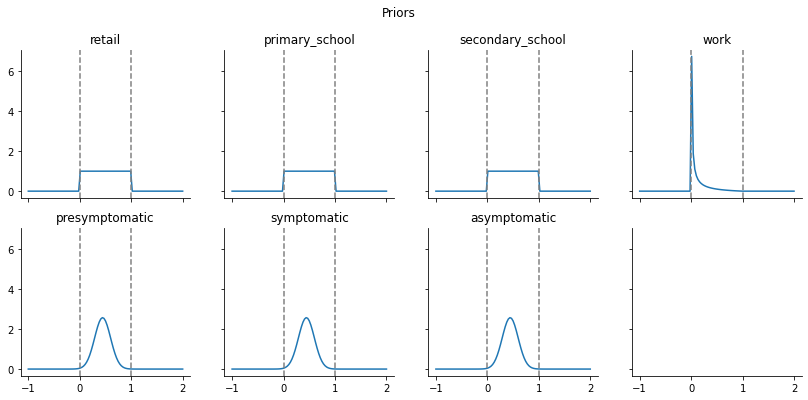

In [6]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

# ax.legend()
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Setup loop for running model

In [7]:
# Path to parameters
parameters_file = os.path.join("../../", "model_parameters/",
                               "default.yml")  # Need to tell it where the default parameters are
# Set the size of a data assimilation window in days:
da_window_size = 14
# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,
                "run_length": da_window_size,
                "current_particle_pop_df": None,
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR,
                "individuals_df": individuals_df, "observations_weekly_array": observations_weekly_array,
                 'num_seed_days' :7}

# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict = {}
weights_dict = {}
history_dict = {}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    # print("Running for 14 days")
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler()
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        # transition=transition,  # Define how to transition from one population to the next
    )

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(
        db=db_path,
        observed_sum_stat=None  # {'observation': observations_array, "individuals": individuals_df}
    )

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history

Window number:  1
Running for 14 days


c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "
ABC.History INFO: Start <ABCSMC id=33, start_time=2022-02-18 09:34:12>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 1 in 0:00:04.683728
OpenclRunner ran model 2 in 0:00:03.337819
OpenclRunner ran model 3 in 0:00:03.482292
OpenclRunner ran model 4 in 0:00:03.518210
OpenclRunner ran model 5 in 0:00:02.877293
OpenclRunner ran model 6 in 0:00:02.436884
OpenclRunner ran model 7 in 0:00:03.556740
OpenclRunner ran model 8 in 0:00:03.484442
OpenclRunner ran model 9 in 0:00:03.590998
OpenclRunner ran model 10 in 0:00:03.520497
OpenclRunner ran model 11 in 0:00:03.442999
OpenclRunner ran model 12 in 0:00:03.449677
OpenclRunner ran model 13 in 0:00:03.359856
OpenclRunner ran model 14 in 0:00:03.032041
OpenclRunner ran model 15 in 0:00:03.523084
OpenclRunner ran model 16 in 0:00:03.372760
OpenclRunner ran model 17 in 0:00:03.714541
OpenclRunner ran model 18 in 0:00:03.657533
OpenclRunner ran model 19 in 0:00:03.671798
OpenclRunner ran model 20 in 0:00:03.381520
OpenclRunner ran model 21 in 0:00:02.958141
OpenclRunner ran model 22 in 0:00:02.836600
OpenclRunner ran model 23 in 0:00:03.1631

ABC INFO: t: 0, eps: 9.33082387e+03.


OpenclRunner ran model 101 in 0:00:03.498780
OpenclRunner ran model 102 in 0:00:03.463530
OpenclRunner ran model 103 in 0:00:03.278559
OpenclRunner ran model 104 in 0:00:03.135706
OpenclRunner ran model 105 in 0:00:03.428348
OpenclRunner ran model 106 in 0:00:03.070237
OpenclRunner ran model 107 in 0:00:03.242927
OpenclRunner ran model 108 in 0:00:03.724957
OpenclRunner ran model 109 in 0:00:03.501261
OpenclRunner ran model 110 in 0:00:03.267643
OpenclRunner ran model 111 in 0:00:03.514684
OpenclRunner ran model 112 in 0:00:03.508700
OpenclRunner ran model 113 in 0:00:02.963535
OpenclRunner ran model 114 in 0:00:03.302860
OpenclRunner ran model 115 in 0:00:03.364358
OpenclRunner ran model 116 in 0:00:03.407065
OpenclRunner ran model 117 in 0:00:03.332129
OpenclRunner ran model 118 in 0:00:02.912604
OpenclRunner ran model 119 in 0:00:03.380410
OpenclRunner ran model 120 in 0:00:03.600463
OpenclRunner ran model 121 in 0:00:03.134216
OpenclRunner ran model 122 in 0:00:02.914290
OpenclRunn

ABC INFO: Accepted: 100 / 165 = 6.0606e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 8.39902802e+03.


OpenclRunner ran model 266 in 0:00:02.941311
OpenclRunner ran model 267 in 0:00:03.636705
OpenclRunner ran model 268 in 0:00:03.476460
OpenclRunner ran model 269 in 0:00:03.461584
OpenclRunner ran model 270 in 0:00:03.766613
OpenclRunner ran model 271 in 0:00:03.803485
OpenclRunner ran model 272 in 0:00:03.559822
OpenclRunner ran model 273 in 0:00:01.804377
OpenclRunner ran model 274 in 0:00:02.154164
OpenclRunner ran model 275 in 0:00:03.564750
OpenclRunner ran model 276 in 0:00:02.999805
OpenclRunner ran model 277 in 0:00:03.209154
OpenclRunner ran model 278 in 0:00:03.576151
OpenclRunner ran model 279 in 0:00:03.604392
OpenclRunner ran model 280 in 0:00:03.423389
OpenclRunner ran model 281 in 0:00:03.601946
OpenclRunner ran model 282 in 0:00:03.543918
OpenclRunner ran model 283 in 0:00:03.550396
OpenclRunner ran model 284 in 0:00:03.511218
OpenclRunner ran model 285 in 0:00:02.922730
OpenclRunner ran model 286 in 0:00:02.800413
OpenclRunner ran model 287 in 0:00:03.487408
OpenclRunn

OpenclRunner ran model 449 in 0:00:02.937963
OpenclRunner ran model 450 in 0:00:02.803388
OpenclRunner ran model 451 in 0:00:02.754785
OpenclRunner ran model 452 in 0:00:03.079967
OpenclRunner ran model 453 in 0:00:02.778257
OpenclRunner ran model 454 in 0:00:02.896639
OpenclRunner ran model 455 in 0:00:02.883247
OpenclRunner ran model 456 in 0:00:02.633260
OpenclRunner ran model 457 in 0:00:03.513660
OpenclRunner ran model 458 in 0:00:03.318733
OpenclRunner ran model 459 in 0:00:02.981485
OpenclRunner ran model 460 in 0:00:03.182829
OpenclRunner ran model 461 in 0:00:03.583596
OpenclRunner ran model 462 in 0:00:03.394620
OpenclRunner ran model 463 in 0:00:03.512174
OpenclRunner ran model 464 in 0:00:03.717982
OpenclRunner ran model 465 in 0:00:03.595540
OpenclRunner ran model 466 in 0:00:03.048881
OpenclRunner ran model 467 in 0:00:03.449128
OpenclRunner ran model 468 in 0:00:03.028571
OpenclRunner ran model 469 in 0:00:02.756765
OpenclRunner ran model 470 in 0:00:03.480921
OpenclRunn

ABC INFO: Accepted: 100 / 274 = 3.6496e-01, ESS: 2.2263e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=33, duration=0:55:47.630569, end_time=2022-02-18 10:30:00>


0
1
Window number:  2
Running for 28 days


ABC.History INFO: Start <ABCSMC id=36, start_time=2022-02-18 10:30:00>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 540 in 0:00:05.219899
OpenclRunner ran model 541 in 0:00:05.902863
OpenclRunner ran model 542 in 0:00:05.092091
OpenclRunner ran model 543 in 0:00:05.683158
OpenclRunner ran model 544 in 0:00:04.523021
OpenclRunner ran model 545 in 0:00:05.338938
OpenclRunner ran model 546 in 0:00:05.654393
OpenclRunner ran model 547 in 0:00:05.397448
OpenclRunner ran model 548 in 0:00:05.017529
OpenclRunner ran model 549 in 0:00:05.247675
OpenclRunner ran model 550 in 0:00:05.331494
OpenclRunner ran model 551 in 0:00:05.595865
OpenclRunner ran model 552 in 0:00:05.243670
OpenclRunner ran model 553 in 0:00:05.187695
OpenclRunner ran model 554 in 0:00:04.728404
OpenclRunner ran model 555 in 0:00:04.843970
OpenclRunner ran model 556 in 0:00:04.950562
OpenclRunner ran model 557 in 0:00:04.466474
OpenclRunner ran model 558 in 0:00:04.044384
OpenclRunner ran model 559 in 0:00:05.668778
OpenclRunner ran model 560 in 0:00:05.074109
OpenclRunner ran model 561 in 0:00:05.634057
OpenclRunn

ABC INFO: t: 0, eps: 4.19755363e+04.


OpenclRunner ran model 640 in 0:00:05.445575
OpenclRunner ran model 641 in 0:00:04.991744
OpenclRunner ran model 642 in 0:00:05.281899
OpenclRunner ran model 643 in 0:00:05.186171
OpenclRunner ran model 644 in 0:00:05.005630
OpenclRunner ran model 645 in 0:00:05.013072
OpenclRunner ran model 646 in 0:00:05.148235
OpenclRunner ran model 647 in 0:00:05.084029
OpenclRunner ran model 648 in 0:00:05.096358
OpenclRunner ran model 649 in 0:00:03.988297
OpenclRunner ran model 650 in 0:00:03.872369
OpenclRunner ran model 651 in 0:00:03.951055
OpenclRunner ran model 652 in 0:00:03.590690
OpenclRunner ran model 653 in 0:00:03.733151
OpenclRunner ran model 654 in 0:00:03.769672
OpenclRunner ran model 655 in 0:00:04.003725
OpenclRunner ran model 656 in 0:00:03.842507
OpenclRunner ran model 657 in 0:00:03.646587
OpenclRunner ran model 658 in 0:00:03.688753
OpenclRunner ran model 659 in 0:00:03.724543
OpenclRunner ran model 660 in 0:00:04.009030
OpenclRunner ran model 661 in 0:00:04.097949
OpenclRunn

OpenclRunner ran model 823 in 0:00:03.384472
OpenclRunner ran model 824 in 0:00:03.446019
OpenclRunner ran model 825 in 0:00:03.434436
OpenclRunner ran model 826 in 0:00:03.390996
OpenclRunner ran model 827 in 0:00:03.233161
OpenclRunner ran model 828 in 0:00:03.422194
OpenclRunner ran model 829 in 0:00:03.421806
OpenclRunner ran model 830 in 0:00:03.250270
OpenclRunner ran model 831 in 0:00:03.352885
OpenclRunner ran model 832 in 0:00:03.521547
OpenclRunner ran model 833 in 0:00:03.295439
OpenclRunner ran model 834 in 0:00:03.397195
OpenclRunner ran model 835 in 0:00:03.254005
OpenclRunner ran model 836 in 0:00:03.195333
OpenclRunner ran model 837 in 0:00:03.382013
OpenclRunner ran model 838 in 0:00:03.351945
OpenclRunner ran model 839 in 0:00:03.169063
OpenclRunner ran model 840 in 0:00:03.421206
OpenclRunner ran model 841 in 0:00:03.405296
OpenclRunner ran model 842 in 0:00:03.411926
OpenclRunner ran model 843 in 0:00:03.336345
OpenclRunner ran model 844 in 0:00:02.981929
OpenclRunn

ABC INFO: Accepted: 100 / 224 = 4.4643e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.27630890e+04.


OpenclRunner ran model 864 in 0:00:03.778485
OpenclRunner ran model 865 in 0:00:04.211071
OpenclRunner ran model 866 in 0:00:03.441773
OpenclRunner ran model 867 in 0:00:03.509196
OpenclRunner ran model 868 in 0:00:03.385438
OpenclRunner ran model 869 in 0:00:03.793899
OpenclRunner ran model 870 in 0:00:03.428718
OpenclRunner ran model 871 in 0:00:03.397562
OpenclRunner ran model 872 in 0:00:03.455174
OpenclRunner ran model 873 in 0:00:03.540828
OpenclRunner ran model 874 in 0:00:03.506248
OpenclRunner ran model 875 in 0:00:03.523843
OpenclRunner ran model 876 in 0:00:03.410495
OpenclRunner ran model 877 in 0:00:03.499811
OpenclRunner ran model 878 in 0:00:03.759677
OpenclRunner ran model 879 in 0:00:03.627275
OpenclRunner ran model 880 in 0:00:03.307814
OpenclRunner ran model 881 in 0:00:03.140959
OpenclRunner ran model 882 in 0:00:03.431241
OpenclRunner ran model 883 in 0:00:03.499587
OpenclRunner ran model 884 in 0:00:03.283014
OpenclRunner ran model 885 in 0:00:03.393746
OpenclRunn

OpenclRunner ran model 1046 in 0:00:05.796516
OpenclRunner ran model 1047 in 0:00:06.086816
OpenclRunner ran model 1048 in 0:00:03.568251
OpenclRunner ran model 1049 in 0:00:03.506815
OpenclRunner ran model 1050 in 0:00:03.536066
OpenclRunner ran model 1051 in 0:00:03.700156
OpenclRunner ran model 1052 in 0:00:03.427996
OpenclRunner ran model 1053 in 0:00:03.613616
OpenclRunner ran model 1054 in 0:00:03.365104
OpenclRunner ran model 1055 in 0:00:03.450728
OpenclRunner ran model 1056 in 0:00:03.425316
OpenclRunner ran model 1057 in 0:00:03.797865
OpenclRunner ran model 1058 in 0:00:03.436751
OpenclRunner ran model 1059 in 0:00:04.293883
OpenclRunner ran model 1060 in 0:00:03.356222
OpenclRunner ran model 1061 in 0:00:03.653766
OpenclRunner ran model 1062 in 0:00:03.261242
OpenclRunner ran model 1063 in 0:00:03.829211
OpenclRunner ran model 1064 in 0:00:03.461025
OpenclRunner ran model 1065 in 0:00:03.811296
OpenclRunner ran model 1066 in 0:00:03.633172
OpenclRunner ran model 1067 in 0:0

ABC INFO: Accepted: 100 / 215 = 4.6512e-01, ESS: 2.4347e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=36, duration=1:28:09.245143, end_time=2022-02-18 11:58:10>


0
1


#### Get results at end of each window

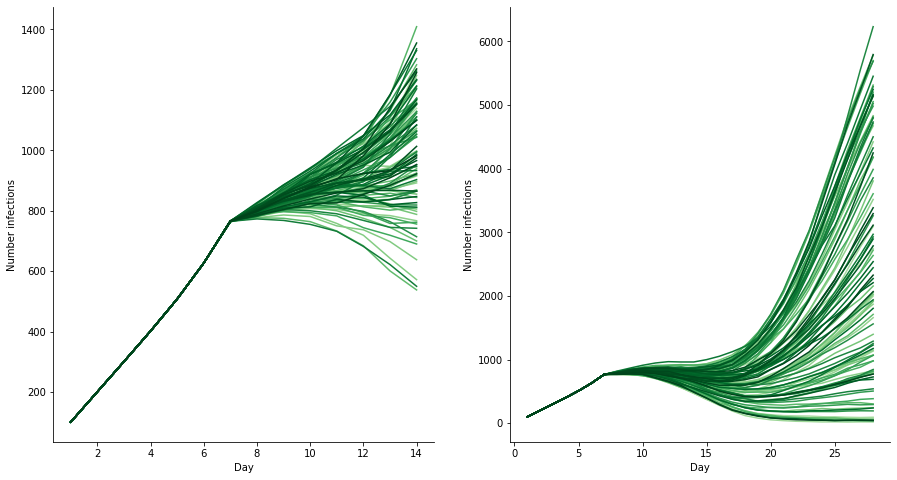

In [8]:
df = pd.DataFrame()
fig, axes = plt.subplots(1, 2, figsize=(15,8))
colors ={'w1': 'darkred', 'w2': 'darkblue'}
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    x=range(1,n_days+1)    
    history  = history_dict[window]   
    weighted_sum_stats_t0 = history.get_weighted_sum_stats_for_model(t=0)[1]
    
    evenly_spaced_interval = np.linspace(0.35, 1, 100)
    colors = [cm.Greens(x) for x in evenly_spaced_interval]
    for particle_no in range(0,100):
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Create dataframe to populate with results
        cumulative_model_diseased_by_area_weekly_sum = pd.DataFrame()
        # Define n weeks
        n_weeks = int(n_days / 7)
        # Loop through each week in n_weeks, find total number of cases in that week
        # for each MSOA, add column to dataframe containing this total
        for i in range(7, (n_weeks * 7) + 7, 7):
            weekly_total = cumulative_model_diseased_by_area.iloc[:, 0:i].sum(axis=1)
            #cumulative_model_diseased_by_area_weekly_sum["week{}Sum".format(int(i / 7))] = weekly_total
        # Sum over MSOAs
        cumulative_model_diseased_by_area_weekly_sum = cumulative_model_diseased_by_area_weekly_sum.sum(axis=0)
        df[particle_no] = cumulative_model_diseased_by_area_devon_sum
        
        axes[axes_number].plot(x,cumulative_model_diseased_by_area_devon_sum, color = colors[particle_no])
 
    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    
    axes_number =axes_number +1

#### Plot the parameter values being used in each window
Doesn't work, unless rerun prior bit at top, not sure why

ValueError: x and y must have same first dimension, but have shapes (99,) and (28,)

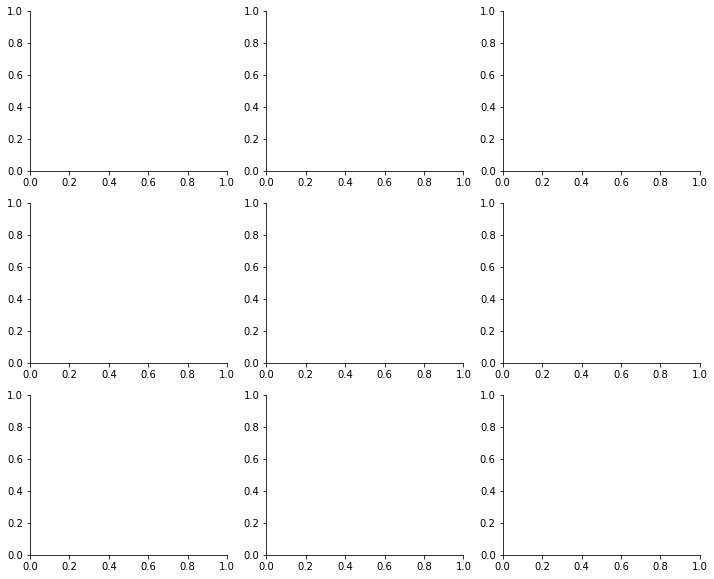

In [9]:
#### Final population for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


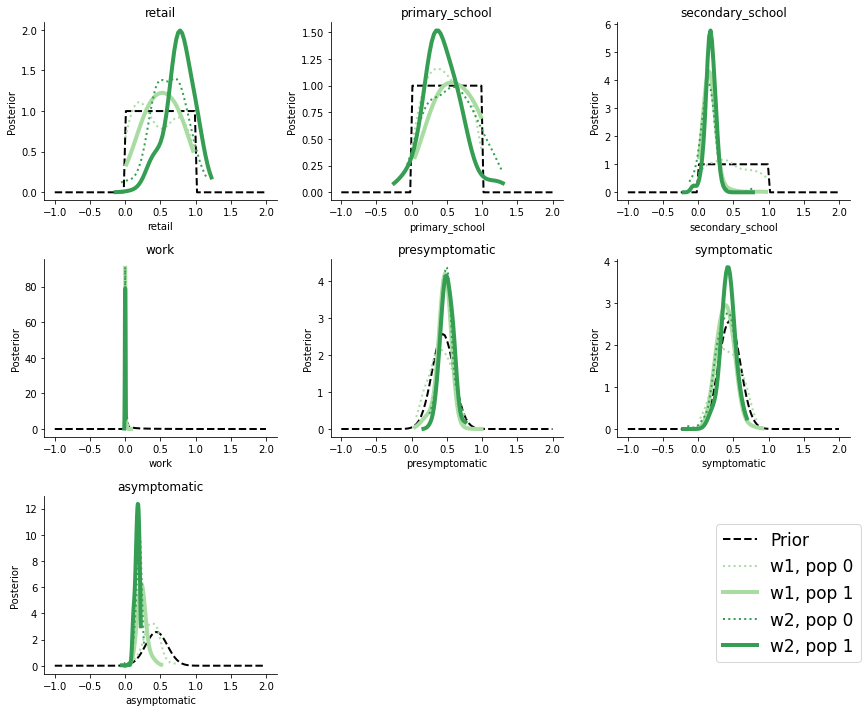

In [39]:
### Plot all populations for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

#### Run the model X (50?) times using paramater values drawn from the posterior
Plot the results to compare the performance of the model with the observations

In [8]:
# Initialise the class so that its ready to run the model.
## Define parameters
PARAMETERS_FILE = os.path.join("../../", "model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer()
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
# assert ITERATIONS < len(OBSERVATIONS), \
# f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

OpenCLRunner.init(iterations=ITERATIONS,
                  repetitions=REPETITIONS,
                  observations=cases_devon_weekly,
                  use_gpu=USE_GPU,
                  use_healthier_pop=USE_HEALTHIER_POP,
                  store_detailed_counts=STORE_DETAILED_COUNTS,
                  parameters_file=PARAMETERS_FILE,
                  opencl_dir=OPENCL_DIR,
                  snapshot_filepath=SNAPSHOT_FILEPATH,
                  num_seed_days = NUM_SEED_DAYS)

# Set constants 
OpenCLRunner.set_constants(const_params_dict)

##### define the abc_history object (not necessary as this will be most recent abc_history anyway)
abc_history = history_dict['w2']

# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    #param_values = {param: sample[str(param)] for param in priors}
    param_values = sample.to_dict()
    print(param_values)
    # Run the model
    # _fitness = fitness (comparison between sim and obs)
    # _sim =  model_weekly_cumulative_infections
    # _obs = obs_weekly_cumulative_infections
    # _out_params = 
    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

# Sanity check - that observations in each case are the same length?
for i in range(len(obs_l) - 1):
    assert np.array_equal(obs_l[0], obs_l[i])

# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode == "save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode == "load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return (fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")

pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

# print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.08352196974751531, 'presymptomatic': 0.6184266833706241, 'primary_school': 0.5026089544392826, 'retail': 0.6567847327623424, 'secondary_school': 0.6249512253433298, 'symptomatic': 0.22749816555223673, 'work': 0.010013251619437063}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


Fitness: 38469.744018084806.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1366957701997505, 'presymptomatic': 0.6383468878178503, 'primary_school': 0.6451856903971499, 'retail': 0.47397744413291965, 'secondary_school': 0.6494405277590893, 'symptomatic': 0.5469048788288419, 'work': 0.001729459977576466}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.15s/it]


Fitness: 24677.367130553328.
{'asymptomatic': 0.007452570283292156, 'presymptomatic': 0.49925606237967135, 'primary_school': 0.32570801166664975, 'retail': 0.7134224642125881, 'secondary_school': 0.9000132700767158, 'symptomatic': 0.21322638191533988, 'work': 0.022392360617649}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.86s/it]


Fitness: 43077.616249866565.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.030324900355822724, 'presymptomatic': 0.34269827889805615, 'primary_school': 0.2498836664530673, 'retail': 0.06810102352904107, 'secondary_school': 0.7167181439051794, 'symptomatic': 0.4764895117206218, 'work': 0.026561720383310714}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.41s/it]


Fitness: 42988.69441204463.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.07134049153620764, 'presymptomatic': 0.3425133606196926, 'primary_school': 1.1949253695483102, 'retail': 0.22373027715168553, 'secondary_school': 0.031840391114905914, 'symptomatic': 0.3051310641250193, 'work': 0.0031592177135206017}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.46s/it]


Fitness: 41543.79843830175.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.01607182422128801, 'presymptomatic': 0.40905808950545486, 'primary_school': 0.5080696889083278, 'retail': 0.5647476023193769, 'secondary_school': 0.9181645867875661, 'symptomatic': 0.15406701219687116, 'work': 0.029074327300142602}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.24s/it]


Fitness: 43055.1965406463.
{'asymptomatic': 0.08443725287523257, 'presymptomatic': 0.22819473783947203, 'primary_school': 0.23608232292240022, 'retail': 0.7874754795445064, 'secondary_school': 0.44352875916455825, 'symptomatic': 0.1193602931499929, 'work': 0.014359094942435622}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.93s/it]


Fitness: 41414.43113106001.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.17931893813806968, 'presymptomatic': 0.06171216560550129, 'primary_school': 0.669043349764181, 'retail': 0.3295007840436881, 'secondary_school': 0.1613180667051824, 'symptomatic': 0.1877632694675675, 'work': 0.0037221749156198213}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]


Fitness: 31690.784384513914.
{'asymptomatic': 0.09453010198070085, 'presymptomatic': 0.2241609992842008, 'primary_school': 0.4626611501575204, 'retail': 0.46764617453507407, 'secondary_school': 0.5159362789868938, 'symptomatic': 0.11480720931073118, 'work': 0.0244941935531726}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.03s/it]


Fitness: 40987.54831227709.
{'asymptomatic': 0.11459028734736595, 'presymptomatic': 0.560104595127602, 'primary_school': 0.37847766067669025, 'retail': 0.2095471823320195, 'secondary_school': 0.8169444161568195, 'symptomatic': 0.2934297593758211, 'work': 0.017950096886202423}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.99s/it]


Fitness: 31979.9272311352.
Found negatives. Resampling
{'asymptomatic': 0.017612385692565014, 'presymptomatic': 0.6043735320856737, 'primary_school': 0.7429640652609492, 'retail': 0.5951881501529301, 'secondary_school': 0.687071140894978, 'symptomatic': 0.3636556892193014, 'work': 0.03758391517399348}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]


Fitness: 42470.130491048185.
Found negatives. Resampling
{'asymptomatic': 0.09023283812669218, 'presymptomatic': 0.6536572717560785, 'primary_school': 0.38168162999965594, 'retail': 0.7198264415531379, 'secondary_school': 0.5023573808405221, 'symptomatic': 0.36834501801421443, 'work': 0.008867654749903794}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


Fitness: 36369.37783485823.
{'asymptomatic': 0.0645501315418835, 'presymptomatic': 0.40581008015816117, 'primary_school': 0.016812305252037613, 'retail': 0.5448233898971687, 'secondary_school': 0.7416709319627014, 'symptomatic': 0.45640272070161825, 'work': 0.02450439248750323}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.08s/it]


Fitness: 41069.41448508927.
Found negatives. Resampling
{'asymptomatic': 0.08782429633727695, 'presymptomatic': 0.6354437171809091, 'primary_school': 0.3100861572300286, 'retail': 0.6490494286601342, 'secondary_school': 0.43368089336867444, 'symptomatic': 0.33520426711947165, 'work': 0.0027775359613570272}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.01s/it]


Fitness: 37770.32204495043.
Found negatives. Resampling
{'asymptomatic': 0.19882877309114283, 'presymptomatic': 0.21805294103976458, 'primary_school': 0.16680388968027796, 'retail': 0.2468291579561948, 'secondary_school': 0.7112594622279422, 'symptomatic': 0.38434543300603113, 'work': 0.008088916053907772}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.10s/it]


Fitness: 20209.71766147196.
{'asymptomatic': 0.1631009884220886, 'presymptomatic': 0.39902798286731644, 'primary_school': 0.8479998922083909, 'retail': 0.2665312067052207, 'secondary_school': 0.569176663670026, 'symptomatic': 0.5456454387741482, 'work': 0.02150726492403384}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.12s/it]


Fitness: 25418.917352851382.
Found negatives. Resampling
{'asymptomatic': 0.03481056756328835, 'presymptomatic': 0.3283594483748764, 'primary_school': 0.4636980964867469, 'retail': 0.5802333097673421, 'secondary_school': 0.8086473447090807, 'symptomatic': 0.17911054564019135, 'work': 0.04111929077852493}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.94s/it]


Fitness: 42830.448826164145.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.05151916747963333, 'presymptomatic': 0.48065720072683465, 'primary_school': 0.49639058715345685, 'retail': 0.7111579188967908, 'secondary_school': 0.5841987622630748, 'symptomatic': 0.3144011703746048, 'work': 0.013601982224694394}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.04s/it]


Fitness: 41919.860433432936.
Found negatives. Resampling
{'asymptomatic': 0.015434511872220225, 'presymptomatic': 0.39770506449181126, 'primary_school': 0.6952510218689488, 'retail': 0.42283351790052603, 'secondary_school': 0.12806071267859404, 'symptomatic': 0.5509539301809449, 'work': 0.01179284228104235}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.03s/it]


Fitness: 42986.857998353924.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.13481248742756957, 'presymptomatic': 0.5653786797805458, 'primary_school': 0.05585160813685276, 'retail': 0.41385647168077455, 'secondary_school': 0.5565655536955526, 'symptomatic': 0.28379873630319186, 'work': 0.019119948426973263}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.02s/it]


Fitness: 29662.817428893824.
{'asymptomatic': 0.055587425178662504, 'presymptomatic': 0.23869289100660876, 'primary_school': 0.803701555424605, 'retail': 0.4007171110968335, 'secondary_school': 0.3059795853421458, 'symptomatic': 0.018749556553484814, 'work': 0.00029420789608343}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.41s/it]


Fitness: 42813.09507451185.
Found negatives. Resampling
{'asymptomatic': 0.013180600213040856, 'presymptomatic': 0.5998855328091955, 'primary_school': 0.8607951965554416, 'retail': 0.59444964834702, 'secondary_school': 0.02951517197775666, 'symptomatic': 0.6863797620615644, 'work': 0.0305470745863098}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]


Fitness: 42621.21280624705.
{'asymptomatic': 0.0025210593833422217, 'presymptomatic': 0.47868728269095456, 'primary_school': 1.1298763130777847, 'retail': 0.5879341393142864, 'secondary_school': 0.1551912821311603, 'symptomatic': 0.17810579999670856, 'work': 0.005102062280407453}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.15s/it]


Fitness: 43243.54177026718.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.0678492652330802, 'presymptomatic': 0.3700934080816727, 'primary_school': 0.2561875413643936, 'retail': 0.2130860712877916, 'secondary_school': 0.6282307955942268, 'symptomatic': 0.48495004522115365, 'work': 0.03607708885502184}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.12s/it]


Fitness: 41487.45195434918.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.06201747032020011, 'presymptomatic': 0.3879335973618387, 'primary_school': 0.6123605247669581, 'retail': 0.6173188338933869, 'secondary_school': 0.6595814870025234, 'symptomatic': 0.1361693368820774, 'work': 0.04532428455394176}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


Fitness: 41825.661269797696.
{'asymptomatic': 0.03113506711614019, 'presymptomatic': 0.5522788976645999, 'primary_school': 0.47143155713669904, 'retail': 0.6349554041025236, 'secondary_school': 0.8014592632297097, 'symptomatic': 0.13389131142134142, 'work': 0.004035263775165259}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.98s/it]


Fitness: 42573.191706973514.
{'asymptomatic': 0.05581177025883249, 'presymptomatic': 0.26428022040610943, 'primary_school': 0.18428914798725438, 'retail': 0.21560203945716933, 'secondary_school': 0.8389455105026485, 'symptomatic': 0.22676358112759387, 'work': 0.03612958638052754}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.03s/it]


Fitness: 42394.61911295659.
{'asymptomatic': 0.07965370168275496, 'presymptomatic': 0.4911337508835354, 'primary_school': 0.059331191345236955, 'retail': 0.45551595785804144, 'secondary_school': 0.5595029123706188, 'symptomatic': 0.08993410090338343, 'work': 0.0033209647755663117}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.02s/it]


Fitness: 40537.506583610164.
Found negatives. Resampling
{'asymptomatic': 0.1295179055823522, 'presymptomatic': 0.0622786691465426, 'primary_school': 0.3036780814128523, 'retail': 0.7431678253324039, 'secondary_school': 0.11520747040885866, 'symptomatic': 0.006951130322432109, 'work': 0.0013196640123037326}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.25s/it]


Fitness: 40374.287448446674.
{'asymptomatic': 0.07387629429417593, 'presymptomatic': 0.37838897340071975, 'primary_school': 0.6260590972611486, 'retail': 0.3775175008419503, 'secondary_school': 0.7501457737978546, 'symptomatic': 0.4286161115074011, 'work': 0.05936431247057804}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.72s/it]

Fitness: 40305.40242012312.
Finished sampling. Ignored 35 negative samples.


#### Plot the individual results for each sample

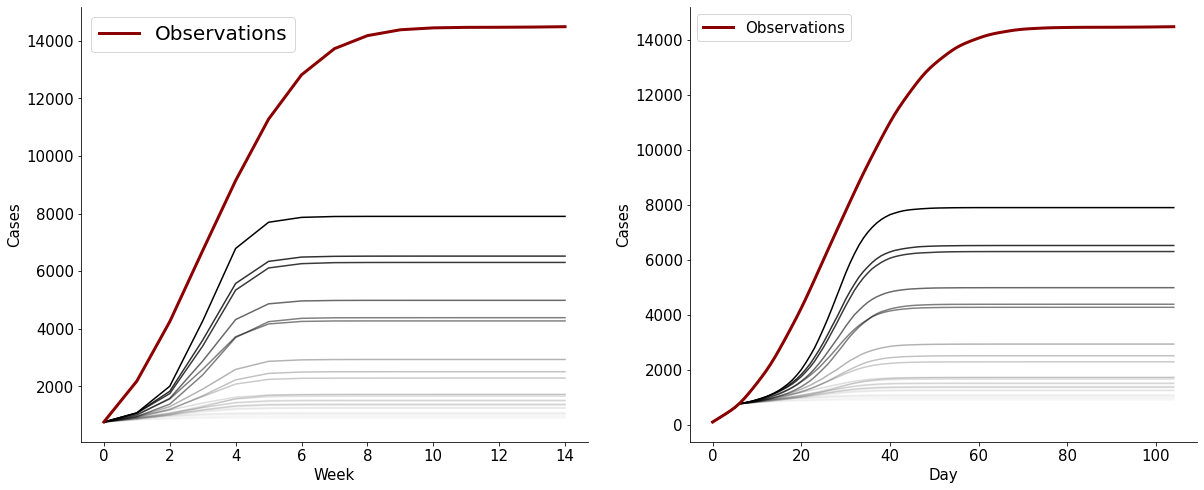

In [9]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i]) # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)

############## PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)

del _fitness, fitness_norm


### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)